# Forest Fires

1. Title: Forest Fires

2. Sources
   Created by: Paulo Cortez and An�bal Morais (Univ. Minho) @ 2007
   
3. Past Usage:

   P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data.
   In Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, 
   December, 2007. (http://www.dsi.uminho.pt/~pcortez/fires.pdf)
   
   In the above reference, the output "area" was first transformed with a ln(x+1) function.
   Then, several Data Mining methods were applied. After fitting the models, the outputs were
   post-processed with the inverse of the ln(x+1) transform. Four different input setups were
   used. The experiments were conducted using a 10-fold (cross-validation) x 30 runs. Two
   regression metrics were measured: MAD and RMSE. A Gaussian support vector machine (SVM) fed
   with only 4 direct weather conditions (temp, RH, wind and rain) obtained the best MAD value:
   12.71 +- 0.01 (mean and confidence interval within 95% using a t-student distribution). The
   best RMSE was attained by the naive mean predictor. An analysis to the regression error curve
   (REC) shows that the SVM model predicts more examples within a lower admitted error. In effect,
   the SVM model predicts better small fires, which are the majority. 
 
4. Relevant Information:

   This is a very difficult regression task. It can be used to test regression methods. Also,
   it could be used to test outlier detection methods, since it is not clear how many outliers
   are there. Yet, the number of examples of fires with a large burned area is very small.

5. Number of Instances: 517 

6. Number of Attributes: 12 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

7. Attribute information:

   For more information, read [Cortez and Morais, 2007].

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform). 

산불 데이터들을 통해서 산불 예측 모델을 만드는 것이 목표이다.

## 설정

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='HCR Batang')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "forestfires"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1. Data Pre-processing

In [2]:
import os
import pandas as pd

def load_forestfires_data(forestfires_path = 'forestfires.csv'):
    return pd.read_csv(forestfires_path)

In [48]:
forestfires = load_forestfires_data()
forestfires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
forestfires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [5]:
forestfires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015FC6F6FDA0>,
      dtype=object)

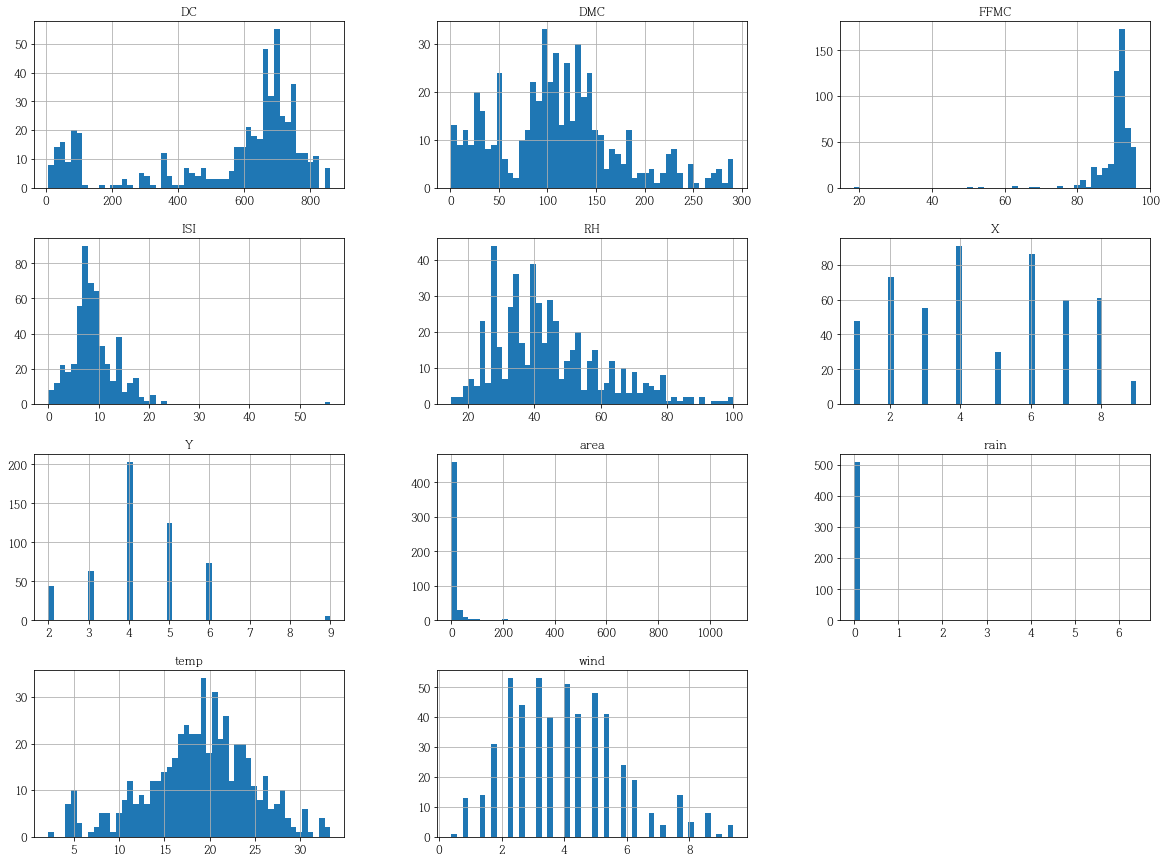

In [6]:
forestfires.hist(bins=50, figsize=(20,15))

In [7]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

### month와 day 숫자화 하기

데이터를 좀더 쉽게 처리하기 위해 datatype이 Object인 것들을 int로 바꾸어 주었다. 월들간, 요일간은 연관이 있기때문에 onehot으로 변환은 하지 않았다.

In [50]:
forestfires["month"].loc[forestfires["month"] == "jan"] = 1
forestfires["month"].loc[forestfires["month"] == "feb"] = 2
forestfires["month"].loc[forestfires["month"] == "mar"] = 3
forestfires["month"].loc[forestfires["month"] == "apr"] = 4
forestfires["month"].loc[forestfires["month"] == "may"] = 5
forestfires["month"].loc[forestfires["month"] == "jun"] = 6
forestfires["month"].loc[forestfires["month"] == "jul"] = 7
forestfires["month"].loc[forestfires["month"] == "aug"] = 8
forestfires["month"].loc[forestfires["month"] == "sep"] = 9
forestfires["month"].loc[forestfires["month"] == "oct"] = 10
forestfires["month"].loc[forestfires["month"] == "nov"] = 11
forestfires["month"].loc[forestfires["month"] == "dec"] = 12

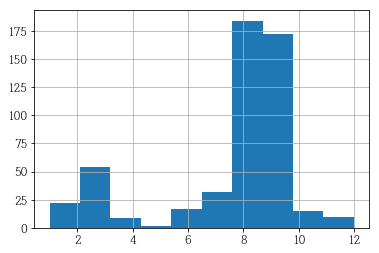

In [52]:
forestfires["month"].hist()

In [54]:
forestfires["day"].loc[forestfires["day"] == "mon"] = 1
forestfires["day"].loc[forestfires["day"] == "tue"] = 2
forestfires["day"].loc[forestfires["day"] == "wed"] = 3
forestfires["day"].loc[forestfires["day"] == "thu"] = 4
forestfires["day"].loc[forestfires["day"] == "fri"] = 5
forestfires["day"].loc[forestfires["day"] == "sat"] = 6
forestfires["day"].loc[forestfires["day"] == "sun"] = 7

c:\users\backg\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


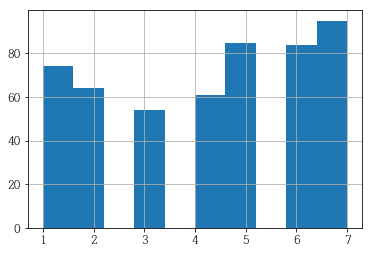

In [56]:
forestfires["day"].hist()

In [62]:
train_set, test_set = split_train_test(forestfires, 0.2)
print(len(train_set), "train +", len(test_set), "test")

414 train + 103 test


In [63]:
train_set.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
206,2,2,8,6,93.5,139.4,594.2,20.3,22.9,31,7.2,0.0,15.45
372,4,5,8,7,92.0,203.2,664.5,8.1,10.4,75,0.9,0.0,0.00
186,8,6,3,7,89.3,51.3,102.2,9.6,11.5,39,5.8,0.0,7.19
173,4,4,9,1,90.9,126.5,686.5,7.0,17.7,39,2.2,0.0,3.07
20,6,4,9,2,91.0,129.5,692.6,7.0,18.3,40,2.7,0.0,0.00


In [64]:
test_set.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
413,7,5,8,6,93.7,231.1,715.1,8.4,26.4,33,3.6,0.0,0.0
316,4,5,9,4,92.4,96.2,739.4,8.6,18.6,24,5.8,0.0,0.0
5,8,6,8,7,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
65,2,2,8,4,91.7,114.3,661.3,6.3,18.6,44,4.5,0.0,0.0
379,4,5,1,7,18.7,1.1,171.4,0.0,5.2,100,0.9,0.0,0.0


In [65]:
train_set.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,4.681159,4.275362,7.446860,4.227053,90.805797,110.793478,550.075362,8.991787,19.158213,43.826087,3.933092,0.026087,11.227802
std,2.328845,1.193819,2.212845,2.039950,4.569736,62.830346,247.576949,4.595917,5.695299,16.097725,1.745473,0.330083,58.590718
min,1.000000,2.000000,2.000000,1.000000,50.400000,2.400000,15.500000,0.400000,4.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,71.550000,438.500000,6.500000,15.900000,32.250000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,4.000000,91.600000,108.300000,665.450000,8.400000,19.350000,41.000000,4.000000,0.000000,0.575000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,141.200000,714.300000,10.600000,22.900000,53.000000,4.900000,0.000000,6.430000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,99.000000,9.400000,6.400000,1090.840000
